# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
from IPython.display import display, clear_output

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
%matplotlib inline


import pyaldata as pyal

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    defs = params.mouse_defs
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root

finally:
    os.chdir(nbPath)
    reload(defs)


read data

In [2]:
@utility.report
def get_full_mouse_data():
    
    animalList = ['mouse-data']
    animalFiles = []
    for animal in animalList:
        animalFiles.extend(utility.find_file(root / animal, 'mat'))

    AllDFs=[]
    for fname in animalFiles:
        df = dt.load_pyal_data(fname)
        df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
        df['file'] = fname.split(os.sep)[-1]
        df = defs.prep_general_mouse(df)
        AllDFs.append(df)

    allDFs_M1 = []
    for df in AllDFs:
        if 'M1_rates' in df.columns:
            allDFs_M1.append(df)


    allDFs_Str = []
    for df in AllDFs:
        if 'Str_rates' in df.columns:
            allDFs_Str.append(df)
            
    return allDFs_M1, allDFs_Str


AllDFs, allDFs_Str = get_full_mouse_data()

clear_output()

Read the example session

In [3]:
def get_example_mouse_data():
    example = defs._example
    animal = 'mouse-data'
    
    example_df = []
    for session in example:
        path = root / animal / session
        df = dt.load_pyal_data(path)
        path = str(path)
        df['mouse'] = path.split(os.sep)[-1][path.split(os.sep)[-1].find('WR'):].split('_')[0]
        df['file'] = path.split(os.sep)[-1]
        df = defs.prep_general_mouse(df)
        df = pyal.restrict_to_interval(df, epoch_fun=defs.exec_epoch)
        example_df.append(df)
        
    return example_df

preprocessing

In [4]:
def plot_colored_line(ax, x, y, colors = None):
    """
    based on this:
    https://matplotlib.org/stable/gallery/lines_bars_and_markers/multicolored_line.html?highlight=multicolored_line
    """
    if colors is None:
        colors = utility.get_colors(x.shape[0])

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, colors=colors)

    lc.set_array(y)
    line = ax.add_collection(lc)
    ax.set_ylim([y.min(),y.max()])
    ax.set_xlim([x.min(),x.max()])
    
    return ax

def plot_3d_colored_line(ax, x, y, z, colors = None, **kwargs):
    """
    based on this:
    https://matplotlib.org/stable/gallery/lines_bars_and_markers/multicolored_line.html?highlight=multicolored_line
    """
    from mpl_toolkits.mplot3d.art3d import Line3DCollection
    
    if colors is None:
        colors = utility.get_colors(x.shape[0])

    points = np.array([x, y, z]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = Line3DCollection(segments, colors=colors, **kwargs)

    lc.set_array(z)
    line = ax.add_collection(lc)
    ax.set_ylim([y.min(),y.max()])
    ax.set_xlim([x.min(),x.max()])
    ax.set_zlim([z.min(),z.max()])
    
    return ax

## Plot FR rasters

In [12]:
raster_example = get_example_mouse_data()
raster_example_df = []
for df in raster_example:
    df = pyal.restrict_to_interval(df, epoch_fun=defs.exec_epoch)
    df = pyal.remove_low_firing_neurons(df, 'M1_rates', 5, divide_by_bin_size=False)
    raster_example_df.append(df)

min_units = min([df.M1_rates[0].shape[1] for df in raster_example_df])
clear_output()

/home/msafaie/REPOS/multi-animal-alignment/packages/pyaldata/pyaldata/firing_rates.py:95: UserWarning: Assuming rates are already in Hz and don't have to divide by bin size.
  utils.warnings.warn("Assuming rates are already in Hz and don't have to divide by bin size.")
/home/msafaie/REPOS/multi-animal-alignment/packages/pyaldata/pyaldata/firing_rates.py:95: UserWarning: Assuming rates are already in Hz and don't have to divide by bin size.
  utils.warnings.warn("Assuming rates are already in Hz and don't have to divide by bin size.")
/home/msafaie/REPOS/multi-animal-alignment/packages/pyaldata/pyaldata/firing_rates.py:95: UserWarning: Assuming rates are already in Hz and don't have to divide by bin size.
  utils.warnings.warn("Assuming rates are already in Hz and don't have to divide by bin size.")
/home/msafaie/REPOS/multi-animal-alignment/packages/pyaldata/pyaldata/firing_rates.py:95: UserWarning: Assuming rates are already in Hz and don't have to divide by bin size.
  utils.warnings

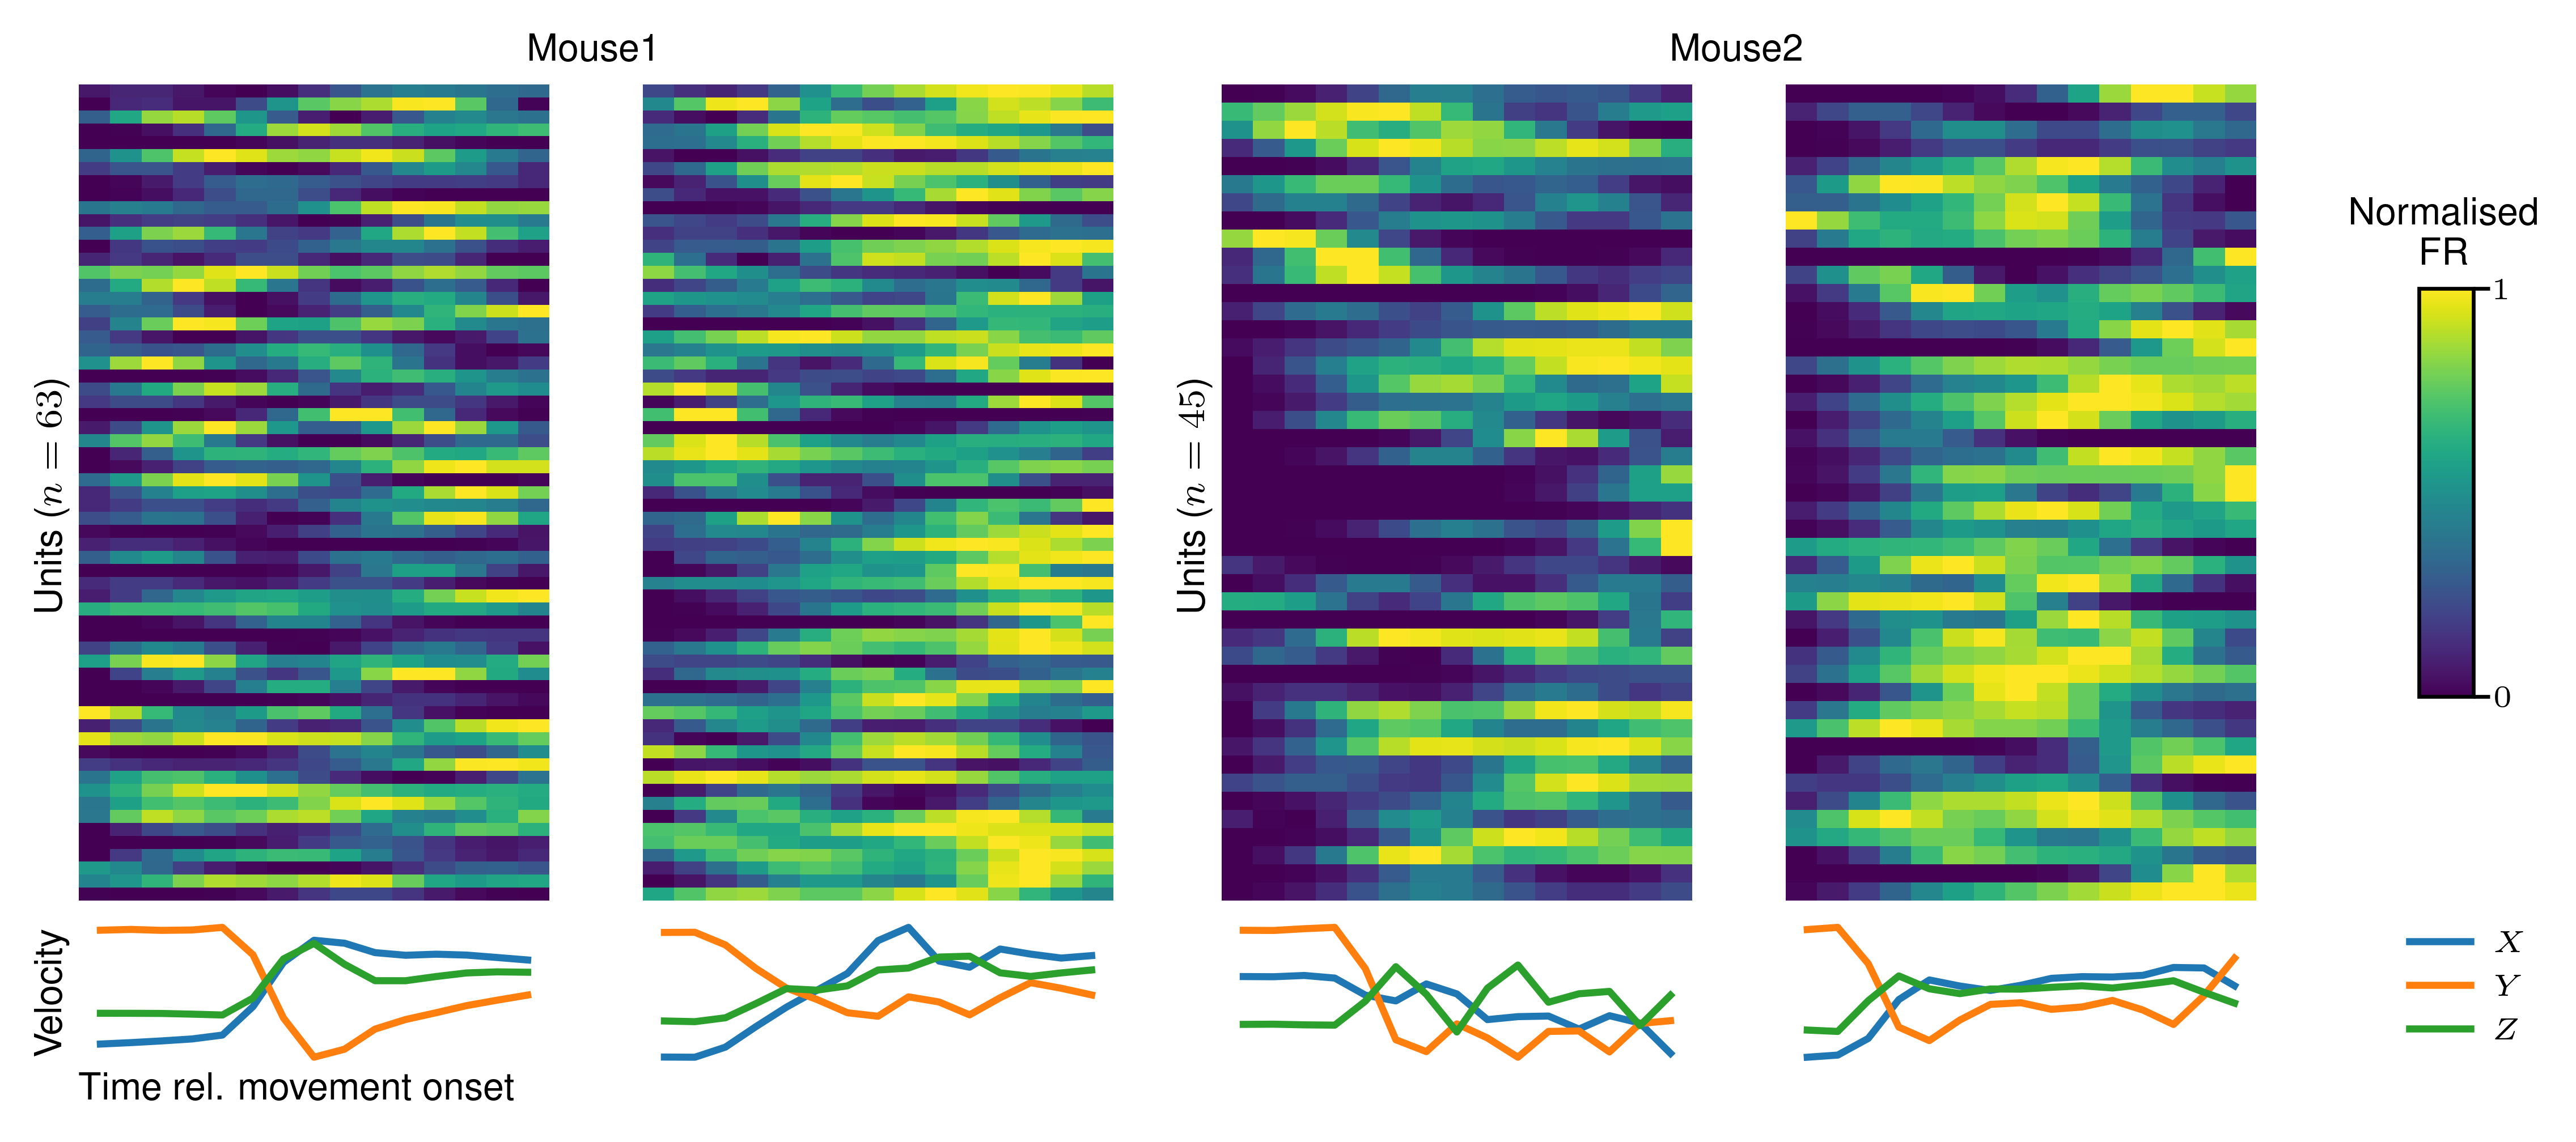

In [17]:
fig = plt.figure(figsize=(8,6))
gs1   =fig.add_gridspec(nrows=1, ncols=defs.n_targets, left=0.1, bottom=0.4, right=.48, top=.8)
gs2   =fig.add_gridspec(nrows=1, ncols=defs.n_targets, left=.52, bottom=0.4, right=.9, top=.8)
gs = [gs1,gs2]
gs_c = fig.add_gridspec(nrows=1, ncols=1, left=.96, bottom=0.5, right=.98, top=.7)
cax = fig.add_subplot(gs_c[:])

trial=0

for i,df in enumerate(raster_example_df):
    axes = []
    data = []
    min_units = np.inf
    for tar in range(2):
        df_ = pyal.select_trials(df, df.target_id==tar)
        df_ = df_.loc[[trial]]
        df_ = pyal.remove_low_firing_neurons(df_, 'M1_rates', 1)
        fr = df_.M1_rates[trial]
        data.append(fr)
        min_units = min([min_units, fr.shape[1]])
    data = np.array([tarData[:,:min_units] for tarData in data])
    vmin = np.amin(data, axis= (0,1))
    vmax = np.amax(data, axis= (0,1))
    for j,tarData in enumerate(data):
        ax = fig.add_subplot(gs[i][j])
        axes.append(ax)
        tarData -= vmin
        tarData /= (vmax - vmin)
        ax.imshow(tarData.T, aspect='auto')
        ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    axes[0].set_ylabel(f'Units ($n={tarData.shape[1]}$)')
fig.colorbar(cm.ScalarMappable(),cax=cax, ticks=(0,1),drawedges=False)
cax.set_title('Normalised\nFR')
ax = utility.phantom_axes(fig.add_subplot(gs1[:]))
ax.set_title('Mouse1')
ax = utility.phantom_axes(fig.add_subplot(gs2[:]))
ax.set_title('Mouse2')

#========================
gs1   =fig.add_gridspec(nrows=1, ncols=defs.n_targets, left=0.1, bottom=0.32, right=.48, top=.39)
gs2   =fig.add_gridspec(nrows=1, ncols=defs.n_targets, left=.52, bottom=0.32, right=.9, top=.39)
gs = [gs1,gs2]

axes = []
for i,df in enumerate(raster_example_df):
    for tar in range(defs.n_targets):
        df_ = pyal.select_trials(df, df.target_id==tar)
        while np.isnan(data := df_.hTrjB[trial]).sum()>0:
            trial +=1
        data -= np.mean(data,axis=0)
        ax = fig.add_subplot(gs[i][tar])
        axes.append(ax)
        ax.plot(data[:,0], label='$X$')
        ax.plot(data[:,1], label='$Y$')
        ax.plot(data[:,2], label='$Z$')
        ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

axes[0].set_ylabel('Velocity')
axes[-1].legend(frameon=False, loc=(1.3,0.04))
axes[0].set_xlabel('Time rel. movement onset',loc='left')

fig.savefig(params.figPath / 'mouse-FR-example.pdf', format='pdf', bbox_inches='tight')

## Same as above for the Str

In [18]:
raster_example = get_example_mouse_data()
raster_example_df = []
for df in raster_example:
    df = pyal.remove_low_firing_neurons(df, 'Str_rates', 1)
    raster_example_df.append(df)

clear_output()

/home/msafaie/REPOS/multi-animal-alignment/packages/pyaldata/pyaldata/firing_rates.py:95: UserWarning: Assuming rates are already in Hz and don't have to divide by bin size.
  utils.warnings.warn("Assuming rates are already in Hz and don't have to divide by bin size.")
/home/msafaie/REPOS/multi-animal-alignment/packages/pyaldata/pyaldata/firing_rates.py:95: UserWarning: Assuming rates are already in Hz and don't have to divide by bin size.
  utils.warnings.warn("Assuming rates are already in Hz and don't have to divide by bin size.")
/home/msafaie/REPOS/multi-animal-alignment/packages/pyaldata/pyaldata/firing_rates.py:95: UserWarning: Assuming rates are already in Hz and don't have to divide by bin size.
  utils.warnings.warn("Assuming rates are already in Hz and don't have to divide by bin size.")
/home/msafaie/REPOS/multi-animal-alignment/packages/pyaldata/pyaldata/firing_rates.py:95: UserWarning: Assuming rates are already in Hz and don't have to divide by bin size.
  utils.warnings

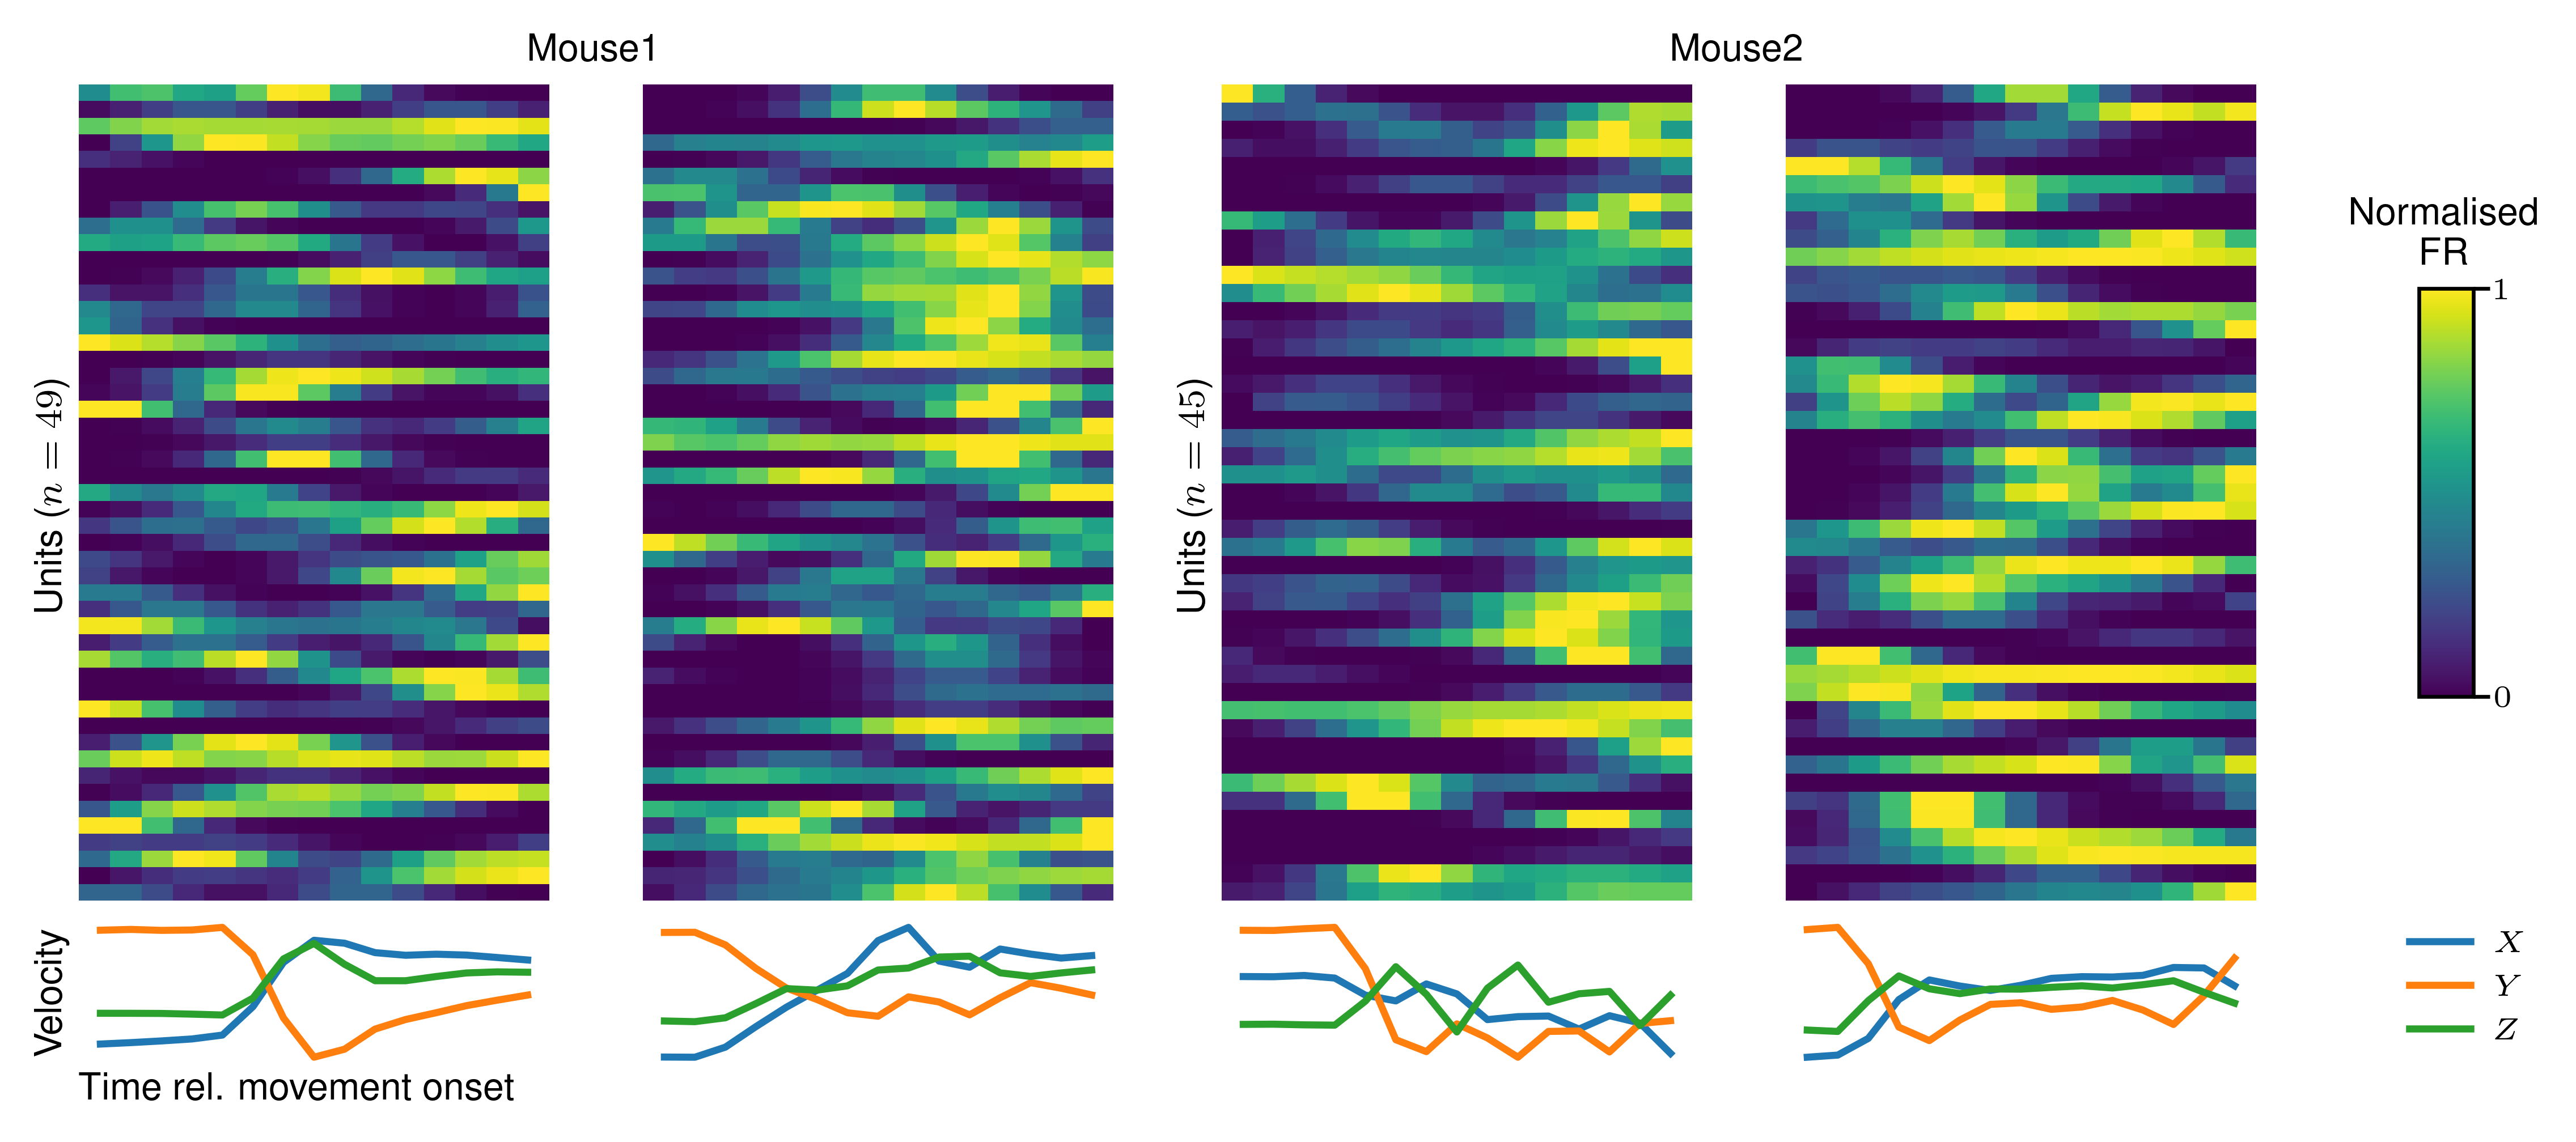

In [19]:
fig = plt.figure(figsize=(8,6))
gs1   =fig.add_gridspec(nrows=1, ncols=defs.n_targets, left=0.1, bottom=0.4, right=.48, top=.8)
gs2   =fig.add_gridspec(nrows=1, ncols=defs.n_targets, left=.52, bottom=0.4, right=.9, top=.8)
gs = [gs1,gs2]
gs_c = fig.add_gridspec(nrows=1, ncols=1, left=.96, bottom=0.5, right=.98, top=.7)
cax = fig.add_subplot(gs_c[:])

trial=0

for i,df in enumerate(raster_example_df):
    axes = []
    data = []
    min_units = np.inf
    for tar in range(2):
        df_ = pyal.select_trials(df, df.target_id==tar)
        df_ = df_.loc[[trial]]
        df_ = pyal.remove_low_firing_neurons(df_, 'Str_rates', 1)
        fr = df_.Str_rates[trial]
        data.append(fr)
        min_units = min([min_units, fr.shape[1]])
    
    data = np.array([tarData[:,:min_units] for tarData in data])
    vmin = np.amin(data, axis= (0,1))
    vmax = np.amax(data, axis= (0,1))
    for j,tarData in enumerate(data):
        ax = fig.add_subplot(gs[i][j])
        axes.append(ax)
        tarData -= vmin
        tarData /= (vmax - vmin)
        ax.imshow(tarData.T, aspect='auto')
        ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    axes[0].set_ylabel(f'Units ($n={tarData.shape[1]}$)')
fig.colorbar(cm.ScalarMappable(),cax=cax, ticks=(0,1),drawedges=False)
cax.set_title('Normalised\nFR')
ax = utility.phantom_axes(fig.add_subplot(gs1[:]))
ax.set_title('Mouse1')
ax = utility.phantom_axes(fig.add_subplot(gs2[:]))
ax.set_title('Mouse2')

#========================
gs1   =fig.add_gridspec(nrows=1, ncols=defs.n_targets, left=0.1, bottom=0.32, right=.48, top=.39)
gs2   =fig.add_gridspec(nrows=1, ncols=defs.n_targets, left=.52, bottom=0.32, right=.9, top=.39)
gs = [gs1,gs2]

axes = []
for i,df in enumerate(raster_example_df):
    for tar in range(defs.n_targets):
        df_ = pyal.select_trials(df, df.target_id==tar)
        while np.isnan(data := df_.hTrjB[trial]).sum()>0:
            trial +=1
        data -= np.mean(data,axis=0)
        ax = fig.add_subplot(gs[i][tar])
        axes.append(ax)
        ax.plot(data[:,0], label='$X$')
        ax.plot(data[:,1], label='$Y$')
        ax.plot(data[:,2], label='$Z$')
        ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

axes[0].set_ylabel('Velocity')
axes[-1].legend(frameon=False, loc=(1.3,0.04))
axes[0].set_xlabel('Time rel. movement onset',loc='left')

fig.savefig(params.figPath / 'mouse-Str-FR-example.pdf', format='pdf', bbox_inches='tight')

## plot 3D trajectories, single trial per target

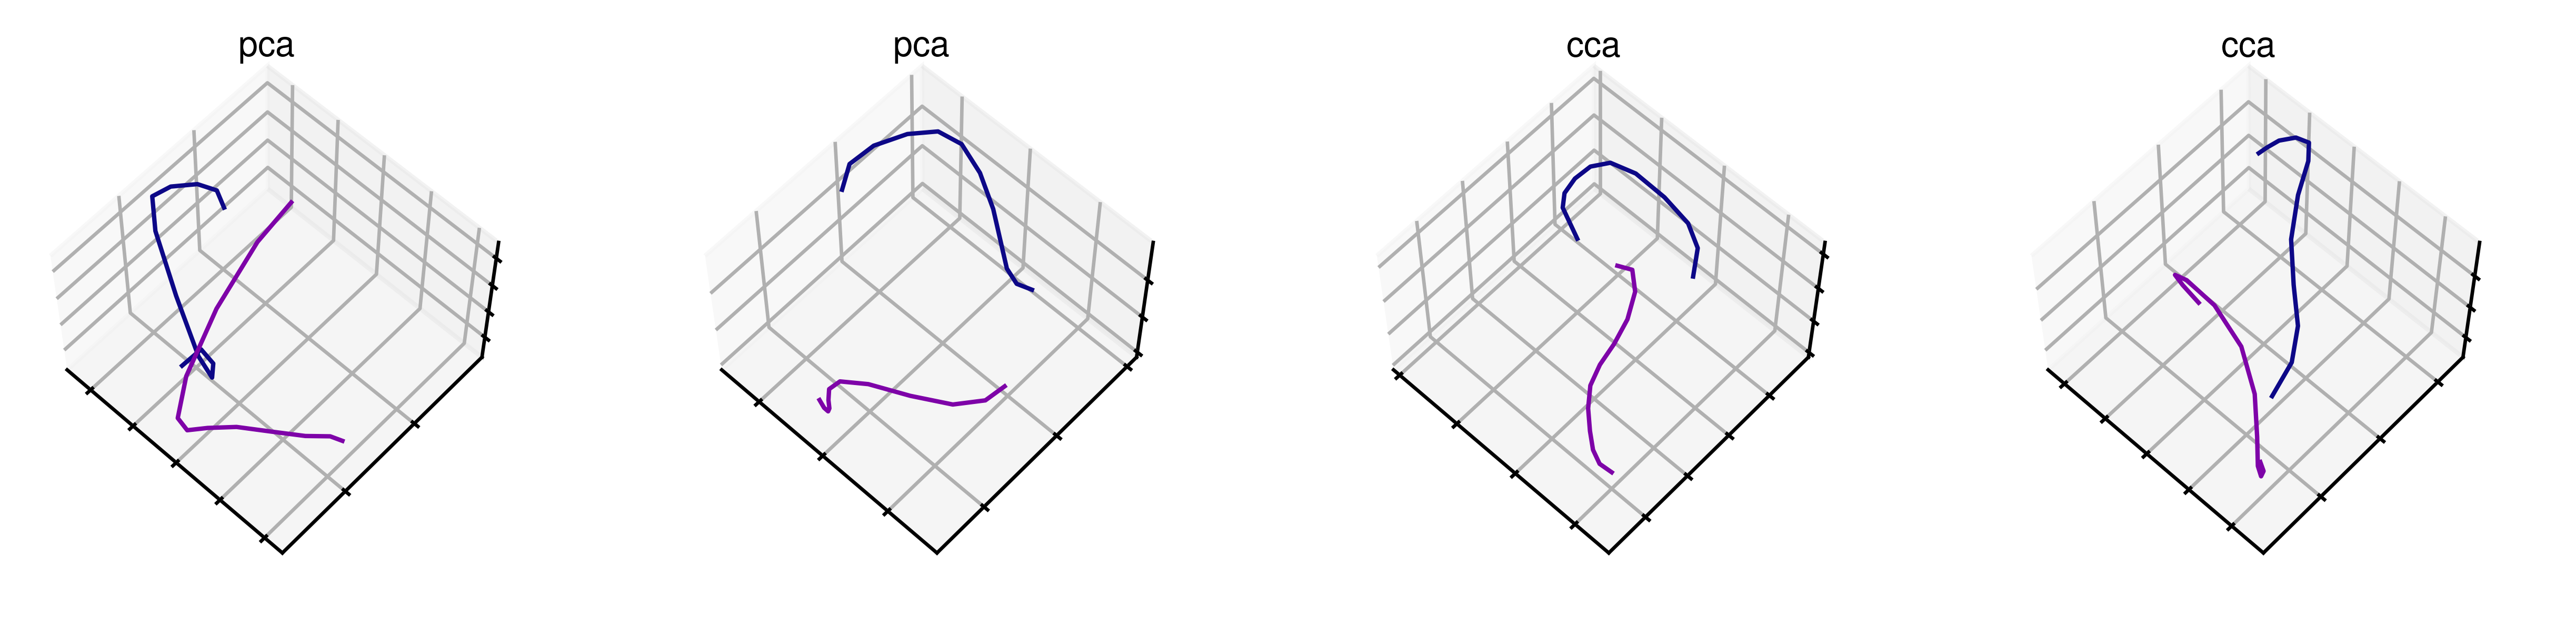

In [9]:
fig = plt.figure(figsize=(10,3))
gs1   =fig.add_gridspec(nrows=1, ncols=2, left=0.1, bottom=0.4, right=.48, top=.9)
gs2   =fig.add_gridspec(nrows=1, ncols=2, left=.52, bottom=0.4, right=.9, top=.9)
gs = [gs1,gs2]
# gs_c = fig.add_gridspec(nrows=1, ncols=1, left=.94, bottom=0.55, right=.96, top=.7)
# cax = fig.add_subplot(gs_c[:])
colors = utility.get_colors(4)

trial=7

dfs=[]
for i,df in enumerate(raster_example_df):
    rates = np.concatenate(df['M1_rates'].values, axis=0)
    rates_model = PCA(n_components=10, svd_solver='full').fit(rates)
    df_ = pyal.apply_dim_reduce_model(df, rates_model, 'M1_rates', '_pca');
    dfs.append(df_)
    ax = fig.add_subplot(gs[0][i], projection='3d',fc='None')
    ax.set_title('pca')
    axes.append(ax)
    for tar in range(2):
        df__ = pyal.select_trials(df_, df_.target_id==tar)
        ex = df__._pca[trial][:,:3]
        ax.plot(ex[:,0],ex[:,1],ex[:,2],color=colors[tar],lw=1)
        ax.set_xticklabels([])          # removes the ticks... great now the rest of it
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        ax.view_init(60,-47)

AllData = dt.get_data_array(raster_example_df, area='M1', model=10)
data1 = np.reshape(AllData[0,...], (-1,10))
data2 = np.reshape(AllData[1,...], (-1,10))
A,B,*_ = dt.canoncorr(data1,data2,fullReturn=True)
coef_ = [A,B]
for i,sessionData in enumerate(AllData):
    ax = fig.add_subplot(gs[1][i], projection='3d',fc='None')
    ax.set_title('cca')
    axes.append(ax)
    for tar in range(2):
        ex = sessionData[tar,trial,...]
        ex = ex @ coef_[i]
        ax.plot(ex[:,0],ex[:,1],ex[:,2],color=colors[tar],lw=1)
        ax.set_xticklabels([])          # removes the ticks... great now the rest of it
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        ax.view_init(60,-47)


the above plotting of a single trial to each target does not show higher correlations as I had hoped

---

## plot 3D trajectories, target averaged

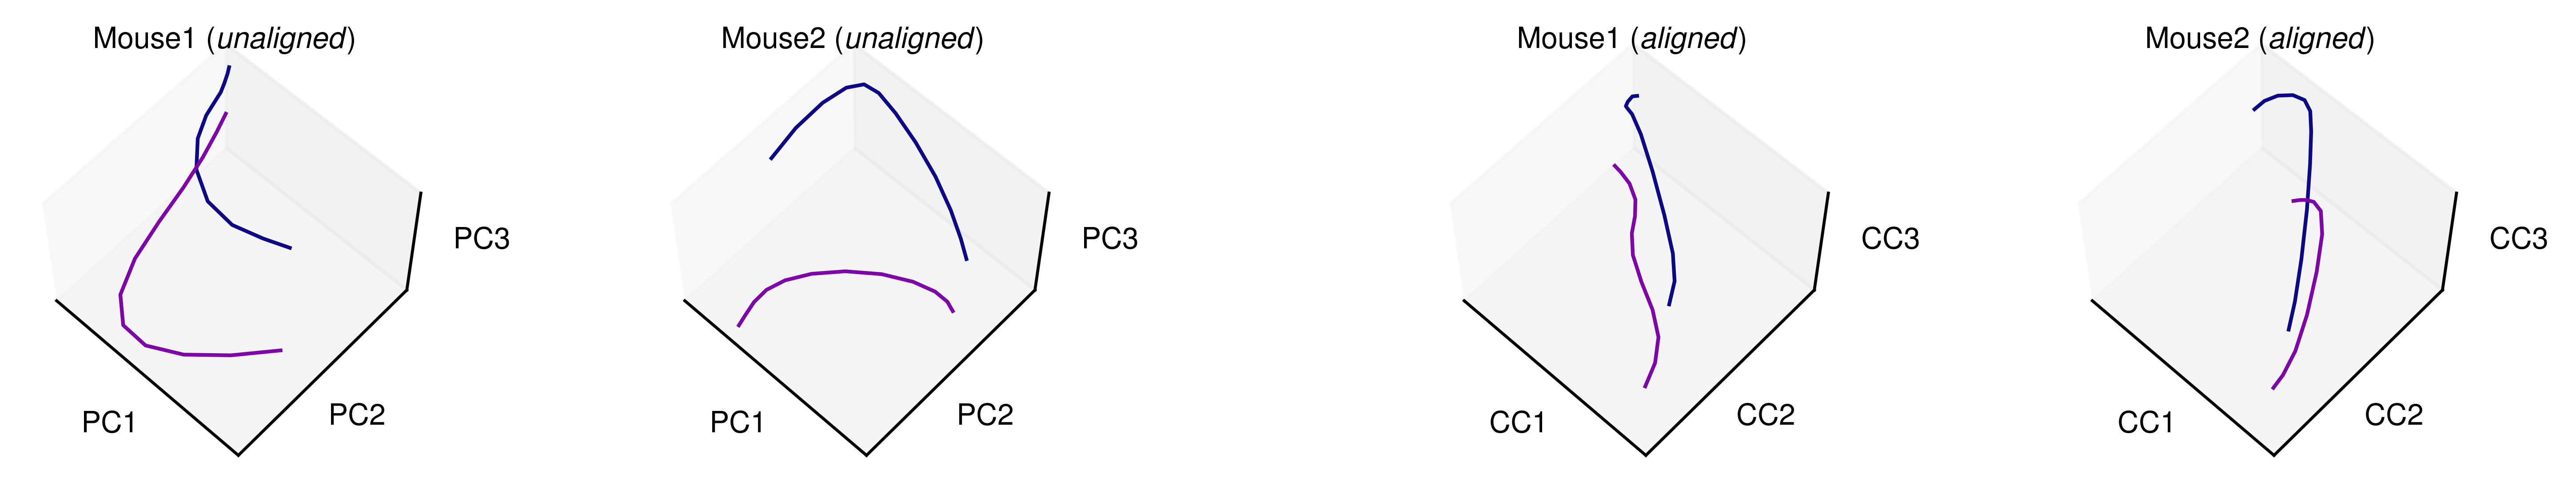

In [10]:
fig = plt.figure(figsize=(12,3))
gs1   =fig.add_gridspec(nrows=1, ncols=2, left=0.1, bottom=0.4, right=.46, top=.9)
gs2   =fig.add_gridspec(nrows=1, ncols=2, left=.54, bottom=0.4, right=.9, top=.9)
gs = [gs1,gs2]

colors = utility.get_colors(4)
dfs=[]
axes=[]
for i,df in enumerate(raster_example_df):
    rates = np.concatenate(df['M1_rates'].values, axis=0)
    rates_model = PCA(n_components=10, svd_solver='full').fit(rates)
    df_ = pyal.apply_dim_reduce_model(df, rates_model, 'M1_rates', '_pca');
    dfs.append(df_)
    ax = fig.add_subplot(gs[0][i], projection='3d',fc='None')
    ax.set_title('pca')
    axes.append(ax)
    for tar in range(2):
        df__ = pyal.select_trials(df_, df_.target_id==tar)
        ex = pyal.get_sig_by_trial(df__,'_pca')
        ex = np.mean(ex, axis=2)[:,:3]
        ax.plot(ex[:,0],ex[:,1],ex[:,2],color=colors[tar],lw=1)
        ax.view_init(60,-47)

AllData = dt.get_data_array(raster_example_df, area='M1', model=10)
data1 = np.reshape(AllData[0,...], (-1,10))
data2 = np.reshape(AllData[1,...], (-1,10))
A,B,*_ = dt.canoncorr(data1,data2,fullReturn=True)
coef_ = [A,B]
for i,sessionData in enumerate(AllData):
    ax = fig.add_subplot(gs[1][i], projection='3d',fc='None')
    ax.set_title('cca')
    axes.append(ax)
    for tar in range(2):
        ex = np.mean(sessionData[tar,...], axis=0)
        ex = ex @ coef_[i]
        ax.plot(ex[:,0],ex[:,1],ex[:,2],color=colors[tar],lw=1)
        ax.view_init(60,-47)
        
titles=[r'Mouse1 (\textit{unaligned})',r'Mouse2 (\textit{unaligned})',
        r'Mouse1 (\textit{aligned})',  r'Mouse2 (\textit{aligned})']
labels = ['PC','PC','CC','CC']
for i, ax in enumerate(axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_xlabel(f'{labels[i]}1', labelpad=-10)
    ax.set_ylabel(f'{labels[i]}2', labelpad=-10)
    ax.set_zlabel(f'{labels[i]}3', labelpad=-10)
    ax.set_title(titles[i], pad=0, loc='center')


fig.savefig(params.figPath / 'mouse-pc-example.pdf', format='pdf', bbox_inches='tight')

# test VAF

In [48]:
reload(dt)

<module 'tools.dataTools' from '/home/mostafa/Repositories/multi-animal-alignment/tools/dataTools.py'>

In [15]:
area = 'M1'
allDFs_M1 = AllDFs
defs = params.mouse_defs
field = area+'_rates'

pairFileList1 = []
for I, df1 in enumerate(allDFs_M1):
    for J, (df2) in enumerate(allDFs_M1):
        if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
        pairFileList1.append((I,J))

dfpairs = [(allDFs_M1[i], allDFs_M1[j]) for i,j in pairFileList1]
dfpairs = dfpairs[:1]
VAFs = np.empty((defs.n_components, len(dfpairs)*2))*np.nan
for i,(df1, df2) in enumerate(dfpairs):
    a,b = dt.VAF_pyal(df1=df1, field1=field, epoch1=defs.exec_epoch,
                      df2=df2, field2=field, epoch2=defs.exec_epoch, n_components=defs.n_components)
    VAFs[:,2*i] = a.cumsum()
    VAFs[:,2*i+1] = b.cumsum()



## New VAF function similar to `get_data_array`

In [3]:
from typing import Callable

In [5]:
def keep_same_number_of_trials(data_list:list[pd.DataFrame], field:str = 'target_id', id_field: str = 'trial_id'):
    """
    keep the same number of trials with the same `field` value in every df.
    trial subselection is random
    `id_field`: a field that is unique to each trial
    """
    rng = params.rng

    if isinstance(data_list, pd.DataFrame):
        data_list = [data_list]

    field_vals = np.unique(data_list[0][field])
    # find the global minimum number of trials with the same `field` value
    n_shared_trial = np.inf
    for df in data_list:
        for val in field_vals:
            df_ = pyal.select_trials(df, df[field] == val)
            n_shared_trial = np.min((df_.shape[0], n_shared_trial))

    n_shared_trial = int(n_shared_trial)

    out = []
    for df in data_list:
        new_df = []
        for target in field_vals:
            df_ = pyal.select_trials(df, df[field] == target)
            all_id = df_[id_field].to_numpy()
            # to guarantee shuffled ids
            while ((all_id_sh := rng.permutation(all_id)) == all_id).all():
                continue
            all_id = all_id_sh
            # select the right number of trials to each target
            df_ = pyal.select_trials(df_, lambda trial: trial[id_field] in all_id[:n_shared_trial])
            new_df.append(df_)
        out.append(pyal.concat_TDs(new_df))
    
    return out


In [14]:

def get_mouse_pca_cca_vaf(data_list: list[pd.DataFrame], epoch: Callable =None , area: str ='M1') -> np.ndarray:
    """
    """
    if isinstance(data_list, pd.DataFrame):
        data_list = [data_list]
    
    model = PCA(n_components=defs.n_components, svd_solver='full')
    
    field = f'{area}_rates'

    pca_VAF = []
    cca_VAF = []
    for I, df1 in enumerate(data_list):
        df1_ = pyal.restrict_to_interval(df1,epoch_fun=epoch)
        rates_1 = np.concatenate(df1_[field].values, axis=0)
        rates_1_model = model.fit(rates_1)
        rates_1_C = rates_1_model.components_
        pca_VAF.append(np.cumsum(rates_1_model.explained_variance_ratio_))

        for J, df2 in enumerate(data_list):
            if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # avoid repetitions

            df1_, df2_ = keep_same_number_of_trials([df1, df2])
            a,b = dt.VAF_pyal(df1=df1_, field1=field, epoch1=epoch,
                              df2=df2_, field2=field, epoch2=epoch,
                              n_components=defs.n_components)
            cca_VAF.append(a.cumsum())
            cca_VAF.append(b.cumsum())
            
    return np.array(pca_VAF).T, np.array(cca_VAF).T

(0.0, 1.0)

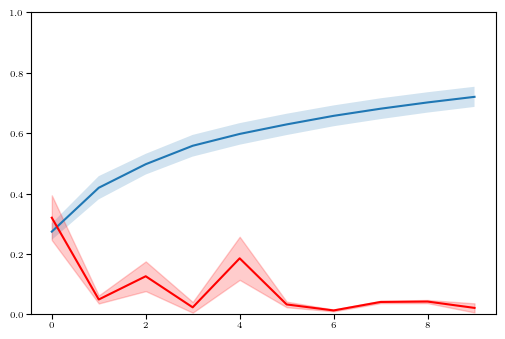

In [15]:
reload(dt)

plt.figure(dpi=100)
pca_vaf, cca_vaf= get_mouse_pca_cca_vaf(data_list=AllDFs[:2], epoch= defs.exec_epoch , area='M1')

utility.shaded_errorbar(plt.gca(), pca_vaf)
utility.shaded_errorbar(plt.gca(), cca_vaf, color = 'r')
plt.ylim([0,1])

In [16]:
pca_vaf.shape, cca_vaf.shape

((10, 2), (10, 2))

In [17]:
pca_vaf, cca_vaf

(array([[0.30146012, 0.24679513],
        [0.45783338, 0.38104483],
        [0.53171456, 0.46315715],
        [0.5943948 , 0.52257603],
        [0.63337606, 0.5619376 ],
        [0.6645296 , 0.5939056 ],
        [0.6920675 , 0.6230998 ],
        [0.71564007, 0.64678335],
        [0.7356673 , 0.6682765 ],
        [0.7538544 , 0.6871118 ]], dtype=float32),
 array([[0.39438891, 0.24613577],
        [0.03628176, 0.06264901],
        [0.1755273 , 0.0772137 ],
        [0.00579989, 0.04114968],
        [0.1143862 , 0.25713703],
        [0.04228713, 0.02377477],
        [0.01022437, 0.01615679],
        [0.03731097, 0.0451878 ],
        [0.04781578, 0.03741519],
        [0.00653066, 0.03670235]]))

In [21]:
cca_vaf.cumsum(axis=0)

array([[0.39438891, 0.24613577],
       [0.43067068, 0.30878478],
       [0.60619798, 0.38599849],
       [0.61199787, 0.42714816],
       [0.72638407, 0.68428519],
       [0.7686712 , 0.70805997],
       [0.77889557, 0.72421676],
       [0.81620654, 0.76940456],
       [0.86402233, 0.80681975],
       [0.87055299, 0.8435221 ]])